In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Bidirectional
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
from datetime import datetime
from tqdm import tqdm
print(f'Current Step #01 [now = {datetime.now()}')
import matplotlib.pyplot as plt


title = "Numbers"
row_length = 150
new_to_old = True
show_mark_down = True
markdown_table_limit_length = 30
candidate = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}

Current Step #01 [now = 2025-07-04 23:32:59.795767


In [37]:
from datetime import datetime


def draw_graph(X, title):
    print(X)
    y = [i for i in range(len(X))]
    plt.figure(figsize=(12, 6))
    plt.plot(y, X, label='Nums')
    plt.xlabel('rounds')
    plt.ylabel('selected')
    plt.title(title)
    plt.legend()
    plt.show()


def draw_average(my_list, length, selected):
    averages = []
    for i in range(len(my_list) - length + 1):
        item_part = my_list[i: i+length]
        average = np.mean(item_part)
        averages.append(float(average))
    # print(averages)
    ordered = averages.copy()
    ordered.sort()
    print(f'최소값 : {ordered[0:5]}')
    print(f'마지막 : {averages[-5:]}')
    draw_scatter([averages], f'average : {selected+1} {length}', True, True)


def draw_scatter(Y: list, title, show_line=True, show_dot=True, show_cols=[0], ext_datas=[], show_label=True):
    import numpy as np
    plt.figure(figsize=(12, 6))
    colors=['b', 'g', 'r', 'c', 'm', 'y']
    if show_line == False and show_dot == False:
        show_line = True
    last = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

    for show_col in show_cols:
        if show_col < len(Y):
            if show_label:
                label = f'Nums{show_col}'            
            else:
                label = ""
            X = [i for i in range(len(Y[show_col]))]
            if show_line:
                plt.plot(X, Y[show_col], label=label, color=colors[show_col])
                label = ""
            if show_dot:
                plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
        last[show_col].append(Y[show_col][-1:][0])
    # print(last)
    if len(ext_datas) > 0:
        for ext in ext_datas:
            if ext[0] < 6 and ext[0] in last:
                show_col = ext[0]
                last[show_col].append(ext[1])
                loc = np.arange(len(Y[0])-1, len(Y[0]) + len(last[show_col])-1)
                if show_line:
                    plt.plot(loc, last[show_col], color='k')
                if show_dot:
                    plt.plot(loc, last[show_col], 'bo', color='k')
    plt.xlabel('rounds')
    plt.ylabel('selected')
    plt.title(title)
    if show_label:
        plt.legend()
    plt.show()


class DataScaling():
    def __init__(self):
        # self._scaler_cls = MinMaxScaler()
        self._scaler_cls = StandardScaler()

    def fit_transform(self, data):
        return self._scaler_cls.fit_transform(data)

    def inverse_transform(self, datas: list):
        inversed_data = []
        cnt = 1
        for data in datas:
            cnt += 1
            if data[1] == True:
                inversed = self._scaler_cls.inverse_transform(data[0].reshape(-1, 1))
            else:
                inversed = self._scaler_cls.inverse_transform(data[0])
            inversed_data.append(inversed)
        return inversed_data


def analyze_v1(random_state,
               row_data,
               layer_count=3,
               activation='sigmoid',
               units=50,
               draw_graph=True,
               sequence_length=10,
               verbose=0):
    # 1. Prepare the Data
    # Create sample time series data
    df = pd.DataFrame(zip(row_data), columns=['matched_cnts'])
    if verbose > 1:
        print('df', df)
    if verbose > 1:
        print(f'Current Step #02 [now = {datetime.now()}]')

    data = df['matched_cnts'].values.reshape(-1, 1)

    # Normalize the data
    scaler = DataScaling()
    scaled_data = scaler.fit_transform(data)
    if verbose > 1:
        print(f'Current Step #04 [now = {datetime.now()}]')

    # Define sequence length (timesteps)

    # Create sequences for training
    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length, 0])
        y.append(scaled_data[i + sequence_length, 0])
    X, y = np.array(X), np.array(y)
    if verbose > 1:
        print(f'Current Step #06 [now = {datetime.now()}]')

    # Reshape X for LSTM input (samples, timesteps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    if verbose > 1:
        print(f'Current Step #08 [now = {datetime.now()}]')

    # Split data into training and testing sets
    # train_size = int(len(X) * 0.8)
    train_size = int(len(X) * 0.9)

    X_train, X_test, X_last = X[:train_size], X[train_size:], np.array([[y[-1:]]])
    y_train, y_test = y[:train_size], y[train_size:]
    if verbose > 1:
        print(f'Current Step #10 [now = {datetime.now()}]')

    tf.random.set_seed(random_state)

    # 2. Build the LSTM Model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    # model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    for i in range(layer_count):
        model.add(LSTM(units=units, return_sequences=True, activation=activation))
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(units=1)) # Output layer for predicting a single value
    if verbose > 1:
        print(f'Current Step #12 [now = {datetime.now()}]')

    # 3. Compile and Train the Model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0) # verbose=0 for silent training

    if verbose > 1:
        print(f'Current Step #14 [now = {datetime.now()}]')
    # 4. Make Predictions
    train_predict = model.predict(X_train, verbose=verbose)
    test_predict = model.predict(X_test, verbose=verbose)
    last_predict = model.predict(X_last, verbose=verbose)
    if verbose > 0:
        print(f'Current Step #16 [now = {datetime.now()}]')

    # Inverse transform predictions to original scale
    scaled_data1 = scaled_data
    wanted_datas = [(train_predict, False),
                    (test_predict, False),
                    (last_predict, True),
                    (y_train, True),
                    (y_test, True),
                    (scaled_data, False)]
    inversed_datas = scaler.inverse_transform(wanted_datas)
    train_predict = inversed_datas[0]
    test_predict = inversed_datas[1]
    last_predict = inversed_datas[2]
    y_train_original = inversed_datas[3]
    y_test_original = inversed_datas[4]
    scaled_data = inversed_datas[5]

    if verbose > 1:
        print(f'Current Step #18 [now = {datetime.now()}]')

    # 5. Evaluate the Model (Optional, but recommended)
    from sklearn.metrics import mean_squared_error
    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_predict))
    test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predict))

    if verbose > 0:
        print(f'Current Step #20 [now = {datetime.now()}]')
        print(f"Train RMSE: {train_rmse}")
        print(f"Test RMSE: {test_rmse}")
        print(f'random_state = {random_state}')
        print(f'last_prediction = {last_predict}')
        print(f'data_max_val = {scaled_data.max()}')
    # You can also visualize the results
    if draw_graph:
        # import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(scaled_data1, label='Original Data')
        plt.plot(np.arange(sequence_length,
                           sequence_length + len(train_predict)),
                 train_predict,
                 label='Train Predictions')
        plt.plot(np.arange(sequence_length + len(train_predict),
                           sequence_length + len(train_predict) + len(test_predict)),
                 test_predict,
                 label='Test Predictions')
        plt.plot(np.arange(sequence_length + len(train_predict) + len(test_predict),
                       sequence_length + len(train_predict) + len(test_predict) + len(last_predict)),
                 last_predict,
                 label='Last Predictions')
        plt.xlabel(f'{random_state}\'s Time Step')
        plt.ylabel('Value')
        plt.legend()
        plt.show()
    return scaled_data.max(), last_predict, random_state


print(f'Current work : {datetime.now()}')

Current work : 2025-07-04 23:58:57.138992


In [30]:
from IPython.display import Markdown
# Define a variable
# Display the variable's value in Markdown
contents = f"### {title}\n"
query = 'select round, metric, bonus from results'
query += f' order by round {"desc" if new_to_old else "asc"}'
limit_str = f'limit {row_length}'
query += f' {limit_str if row_length > 0 else ""}'
rows = !echo "{query}"| sqlite3 ../db/metrics.db
table_rows = ["|round|numbers|bonus|sum|0|10|20|30|40|",
              "|--|--|--|--|--|--|--|--|--|"
             ]
rows_dict = {1:[], 10:[], 20:[], 30:[], 40:[]}
nums_t = []
sums = []
cur_table_limit = 0
print(f'row\'s len = {len(rows)}')
for row in rows:
    cols = row.split('|')
    if len(cols) == 3:
        num_00 = 0
        num_10 = 0
        num_20 = 0
        num_30 = 0
        num_40 = 0
        nums_list = [int(i) for i in cols[1].split(',')]
        for num in nums_list:
            if num < 10:
                num_00 += 1
            if num >= 10 and num < 20:
                num_10 += 1
            if num >= 20 and num < 30:
                num_20 += 1
            if num >= 30 and num < 40:
                num_30 += 1
            if num >= 40 :
                num_40 += 1
        rows_dict[1].append(num_00)
        rows_dict[10].append(num_10)
        rows_dict[20].append(num_20)
        rows_dict[30].append(num_30)
        rows_dict[40].append(num_40)
        if cur_table_limit < markdown_table_limit_length:
            nums=[f"{i:02}" for i in nums_list] 
            table_rows.append(f"|{cols[0]}|{",".join(nums)}|{cols[2]}|{sum(nums_list)}|{num_00}|{num_10}|{num_20}|{num_30}|{num_40}|")
            cur_table_limit += 1
        nums_t.append(nums_list)
        sums.append(sum(nums_list))
sums.reverse()
table_rows_str = "\n".join(table_rows)
contents+=table_rows_str
Markdown(contents)

row's len = 150


### Numbers
|round|numbers|bonus|sum|0|10|20|30|40|
|--|--|--|--|--|--|--|--|--|
|1179|05,06,11,27,43,44|17|136|2|1|1|0|2|
|1178|05,06,11,27,43,44|17|136|2|1|1|0|2|
|1177|03,07,15,16,19,43|21|103|2|3|0|0|1|
|1176|07,09,11,21,30,35|29|113|2|1|1|2|0|
|1175|03,04,06,08,32,42|31|95|4|0|0|1|1|
|1174|08,11,14,17,36,39|22|125|1|3|0|2|0|
|1173|01,05,18,20,30,35|3|109|2|1|1|2|0|
|1172|07,09,24,40,42,44|45|166|2|0|1|0|3|
|1171|03,06,07,11,12,17|19|56|3|3|0|0|0|
|1170|03,13,28,34,38,42|25|158|1|1|1|2|1|
|1169|05,12,24,26,39,42|20|148|1|1|2|1|1|
|1168|09,21,24,30,33,37|29|154|1|0|2|3|0|
|1167|08,23,31,35,39,40|24|176|1|0|1|3|1|
|1166|14,23,25,27,29,42|16|160|0|1|4|0|1|
|1165|06,07,27,29,38,45|17|152|2|0|2|1|1|
|1164|17,18,23,25,38,39|22|160|0|2|2|2|0|
|1163|02,13,15,16,33,43|4|122|1|3|0|1|1|
|1162|20,21,22,25,28,29|6|145|0|0|6|0|0|
|1161|02,12,20,24,34,42|37|134|1|1|2|1|1|
|1160|07,13,18,36,39,45|19|158|1|2|0|2|1|
|1159|03,09,27,28,38,39|7|144|2|0|2|2|0|
|1158|21,25,27,32,37,38|20|180|0|0|3|3|0|
|1157|05,07,12,20,25,26|28|95|2|1|3|0|0|
|1156|30,31,34,39,41,45|7|220|0|0|0|4|2|
|1155|10,16,19,27,37,38|13|147|0|3|1|2|0|
|1154|04,08,22,26,32,38|27|130|2|0|2|2|0|
|1153|01,09,10,13,35,44|5|112|2|2|0|1|1|
|1152|30,31,32,35,36,37|5|201|0|0|0|6|0|
|1151|02,03,09,15,27,29|8|85|3|1|2|0|0|
|1150|08,09,18,35,39,45|25|154|2|1|0|2|1|

In [31]:
nums_t
nums_by_row = [[] for i in range(6)]
for nums in nums_t:
    for i in range(6):
        nums_by_row[i].append(nums[i])
for i in range(6):
    nums_by_row[i].reverse()

/tmp/ipykernel_3120/4090423861.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
/tmp/ipykernel_3120/4090423861.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(loc, last[show_col], 'bo', color='k')


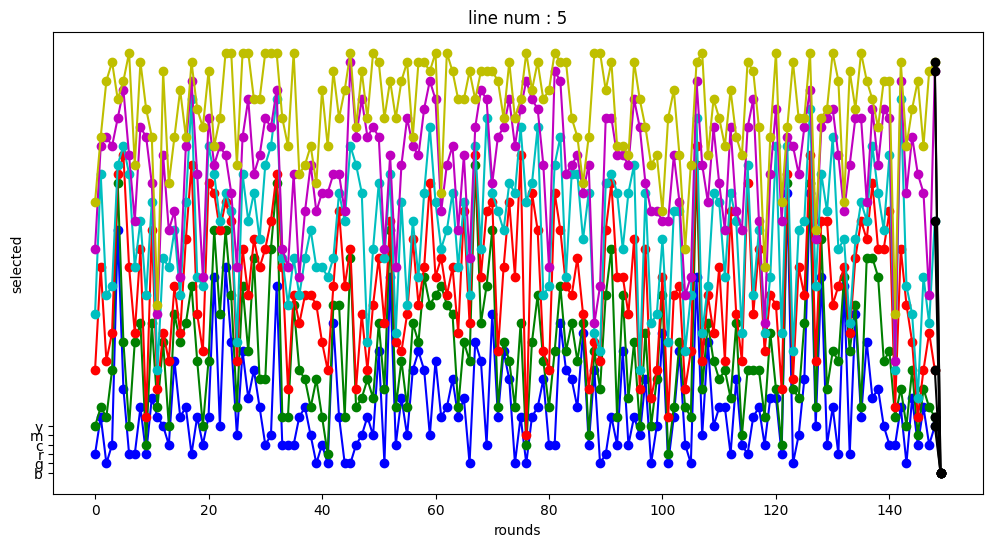

In [32]:
# for i in range(6):
#     draw_scatter([nums_by_row[i]], f'Line Num : {i+1}')
row_list = []
row_list_none_last = []
for nums in nums_by_row:
    row_list.append(nums[0:-1])
    row_list_none_last.append(nums[0: len(nums)-1])
# ext_datas =  [(0,1), (1,2), (2,3), (3,4), (4,5), (5,6)]
# ext_datas =  [(0, 3), (1,7), (2,12), (3,26), (4,33), (5,40)]
ext_datas = []
for key in candidate:
    ext_datas.append((key, candidate[key]))

# show_cols = [0, 1, 2, 3, 4, 5]
show_cols = [0, 1, 2, 3, 4, 5]

show_label = False


draw_scatter(row_list, f'line num : {key}', True, True, show_cols, ext_datas, show_label)


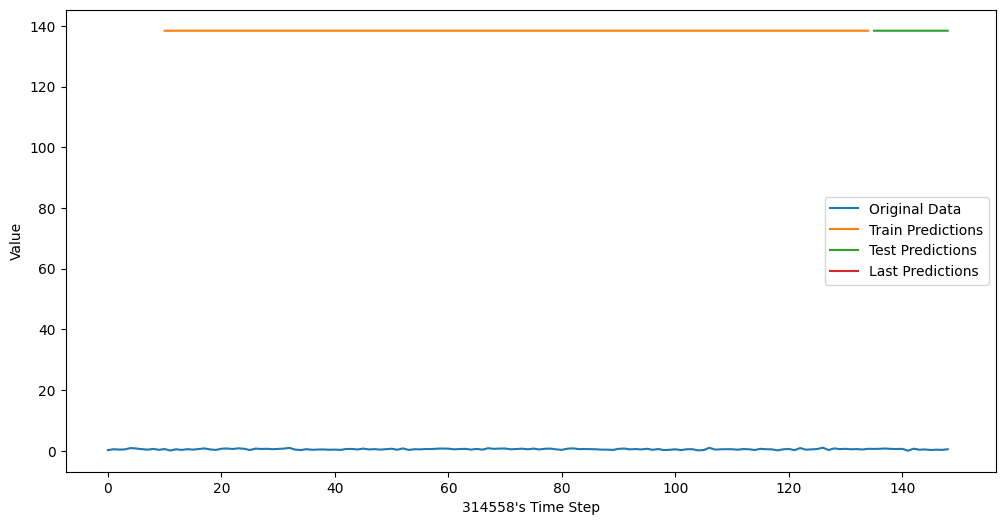

In [33]:
scaled_data_max, last_predict, random_state = analyze_v1(random_state=314558,
                                                         row_data=sums[:-1],
                                                         layer_count=3,
                                                         activation='sigmoid',
                                                         units=50,
                                                         draw_graph=True,
                                                         sequence_length=10,
                                                         verbose=0)

In [34]:
print(scaled_data_max, last_predict, random_state)

220.0 [[127.895134]] 314558


/tmp/ipykernel_39198/3843253644.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])


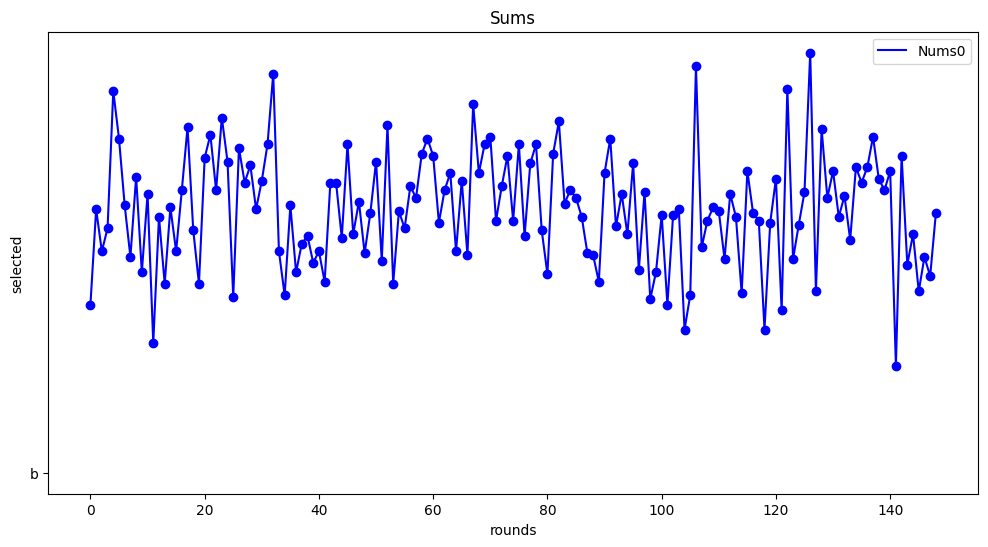

last : [158, 56, 166, 109, 125, 95, 113, 103, 136]


In [49]:
draw_scatter([sums[:-1]] + [sum(candidate.values())], f'Sums')
print(f'last : {sums[-10:-1]}')

In [36]:
predicted = []
for selected in range(6):
    print(f'selected = {selected}')
    my_list = row_list_none_last[selected]
    scaled_data_max, last_predict, random_state = analyze_v1(random_state=314558,
                                                             row_data=my_list,
                                                             layer_count=3,
                                                             activation='sigmoid',
                                                             units=50,
                                                             draw_graph=False,
                                                             sequence_length=10,
                                                             verbose=2)
    predicted.append((scaled_data_max, last_predict, random_state))
for p in predicted:
    print(p)

df      matched_cnts
0               2
1               6
2               1
3               3
4              26
..            ...
144             8
145             3
146             7
147             3
148             5

[149 rows x 1 columns]
Current Step #02 [now = 2025-07-04 23:50:43.759511]
Current Step #04 [now = 2025-07-04 23:50:43.760237]
Current Step #06 [now = 2025-07-04 23:50:43.760435]
Current Step #08 [now = 2025-07-04 23:50:43.760468]
Current Step #10 [now = 2025-07-04 23:50:43.760495]
Current Step #12 [now = 2025-07-04 23:50:43.922950]
Current Step #14 [now = 2025-07-04 23:51:34.869201]
4/4 - 1s - 141ms/step
1/1 - 0s - 22ms/step
1/1 - 0s - 313ms/step
Current Step #16 [now = 2025-07-04 23:51:35.853633]
Current Step #18 [now = 2025-07-04 23:51:35.855295]
Current Step #20 [now = 2025-07-04 23:51:35.856262]
Train RMSE: 6.030007632387818
Test RMSE: 3.933645185820909
random_state = 314558
last_prediction = [[6.1207676]]
data_max_val = 30.000000000000004
df      matched_cnts
0   

In [38]:
predicted = []
for selected in range(6):
    print(f'selected = {selected}')
    my_list = row_list_none_last[selected]
    scaled_data_max, last_predict, random_state = analyze_v1(random_state=314558,
                                                             row_data=my_list,
                                                             layer_count=3,
                                                             activation='sigmoid',
                                                             units=50,
                                                             draw_graph=False,
                                                             sequence_length=10,
                                                             verbose=2)
    predicted.append((scaled_data_max, last_predict, random_state))
for p in predicted:
    print(p)

selected = 0
df      matched_cnts
0               2
1               6
2               1
3               3
4              26
..            ...
144             8
145             3
146             7
147             3
148             5

[149 rows x 1 columns]
Current Step #02 [now = 2025-07-04 23:59:28.908311]
Current Step #04 [now = 2025-07-04 23:59:28.908846]
Current Step #06 [now = 2025-07-04 23:59:28.909000]
Current Step #08 [now = 2025-07-04 23:59:28.909018]
Current Step #10 [now = 2025-07-04 23:59:28.909033]
Current Step #12 [now = 2025-07-04 23:59:29.037975]
Current Step #14 [now = 2025-07-05 00:00:30.577389]
4/4 - 1s - 184ms/step
1/1 - 0s - 33ms/step
1/1 - 0s - 363ms/step
Current Step #16 [now = 2025-07-05 00:00:31.812760]
Current Step #18 [now = 2025-07-05 00:00:31.813778]
Current Step #20 [now = 2025-07-05 00:00:31.814312]
Train RMSE: 5.763785658715639
Test RMSE: 3.3773352040516125
random_state = 314558
last_prediction = [[7.3217187]]
data_max_val = 30.0
selected = 1
df      matc

In [39]:
predicted = []
for selected in range(6):
    print(f'selected = {selected}')
    my_list = row_list_none_last[selected][:-1]
    scaled_data_max, last_predict, random_state = analyze_v1(random_state=314558,
                                                             row_data=my_list,
                                                             layer_count=3,
                                                             activation='sigmoid',
                                                             units=50,
                                                             draw_graph=False,
                                                             sequence_length=10,
                                                             verbose=2)
    predicted.append((scaled_data_max, last_predict, random_state))
for p in predicted:
    print(p)

selected = 0
df      matched_cnts
0               2
1               6
2               1
3               3
4              26
..            ...
143             1
144             8
145             3
146             7
147             3

[148 rows x 1 columns]
Current Step #02 [now = 2025-07-05 00:10:14.521566]
Current Step #04 [now = 2025-07-05 00:10:14.522368]
Current Step #06 [now = 2025-07-05 00:10:14.522616]
Current Step #08 [now = 2025-07-05 00:10:14.522659]
Current Step #10 [now = 2025-07-05 00:10:14.522683]
Current Step #12 [now = 2025-07-05 00:10:14.666342]
Current Step #14 [now = 2025-07-05 00:11:13.022822]
4/4 - 1s - 170ms/step
1/1 - 0s - 29ms/step
1/1 - 0s - 372ms/step
Current Step #16 [now = 2025-07-05 00:11:14.470553]
Current Step #18 [now = 2025-07-05 00:11:14.472122]
Current Step #20 [now = 2025-07-05 00:11:14.472841]
Train RMSE: 5.725950275759578
Test RMSE: 3.988466468264931
random_state = 314558
last_prediction = [[7.5903482]]
data_max_val = 30.0
selected = 1
df      match

In [45]:
print(datetime.now())
predicted = []
for selected in range(6):
    print(f'selected = {selected}')
    my_list = row_list_none_last[selected][:-1]
    scaled_data_max, last_predict, random_state = analyze_v1(random_state=30014558,
                                                             row_data=my_list,
                                                             layer_count=1,
                                                             activation='tanh',
                                                             units=6,
                                                             draw_graph=False,
                                                             sequence_length=10,
                                                             verbose=2)
    predicted.append((scaled_data_max, last_predict, random_state))
for p in predicted:
    print(p)

2025-07-05 00:55:07.006337
selected = 0
df      matched_cnts
0               2
1               6
2               1
3               3
4              26
..            ...
143             1
144             8
145             3
146             7
147             3

[148 rows x 1 columns]
Current Step #02 [now = 2025-07-05 00:55:07.008634]
Current Step #04 [now = 2025-07-05 00:55:07.009161]
Current Step #06 [now = 2025-07-05 00:55:07.009312]
Current Step #08 [now = 2025-07-05 00:55:07.009331]
Current Step #10 [now = 2025-07-05 00:55:07.009346]
Current Step #12 [now = 2025-07-05 00:55:07.081681]
Current Step #14 [now = 2025-07-05 00:55:28.863377]
4/4 - 0s - 71ms/step
1/1 - 0s - 20ms/step
1/1 - 0s - 155ms/step
Current Step #16 [now = 2025-07-05 00:55:29.401284]
Current Step #18 [now = 2025-07-05 00:55:29.402250]
Current Step #20 [now = 2025-07-05 00:55:29.402729]
Train RMSE: 5.569540108329422
Test RMSE: 4.139664622860546
random_state = 30014558
last_prediction = [[8.11678]]
data_max_val = 30.0


In [ ]:
(np.float64(30.000000000000004), array([[6.1207676]], dtype=float32), 314558)
(np.float64(33.0), array([[4.0026402]], dtype=float32), 314558)
(np.float64(35.0), array([[15.271533]], dtype=float32), 314558)
(np.float64(40.0), array([[29.240566]], dtype=float32), 314558)
(np.float64(44.0), array([[37.42968]], dtype=float32), 314558)
(np.float64(45.0), array([[32.72621]], dtype=float32), 314558)

(np.float64(30.0), array([[7.3217187]], dtype=float32), 314558)
(np.float64(33.0), array([[13.810979]], dtype=float32), 314558)
(np.float64(35.0), array([[19.010557]], dtype=float32), 314558)
(np.float64(40.0), array([[25.239151]], dtype=float32), 314558)
(np.float64(44.0), array([[34.730366]], dtype=float32), 314558)
(np.float64(45.0), array([[38.54149]], dtype=float32), 314558)

(np.float64(30.0), array([[8.11678]], dtype=float32), 30014558)
(np.float64(33.0), array([[13.650756]], dtype=float32), 30014558)
(np.float64(35.0), array([[19.386393]], dtype=float32), 30014558)
(np.float64(40.0), array([[25.771692]], dtype=float32), 30014558)
(np.float64(44.0), array([[32.6605]], dtype=float32), 30014558)
(np.float64(45.0), array([[39.21304]], dtype=float32), 30014558)

/tmp/ipykernel_39198/3843253644.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
/tmp/ipykernel_39198/3843253644.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(loc, last[show_col], 'bo', color='k')


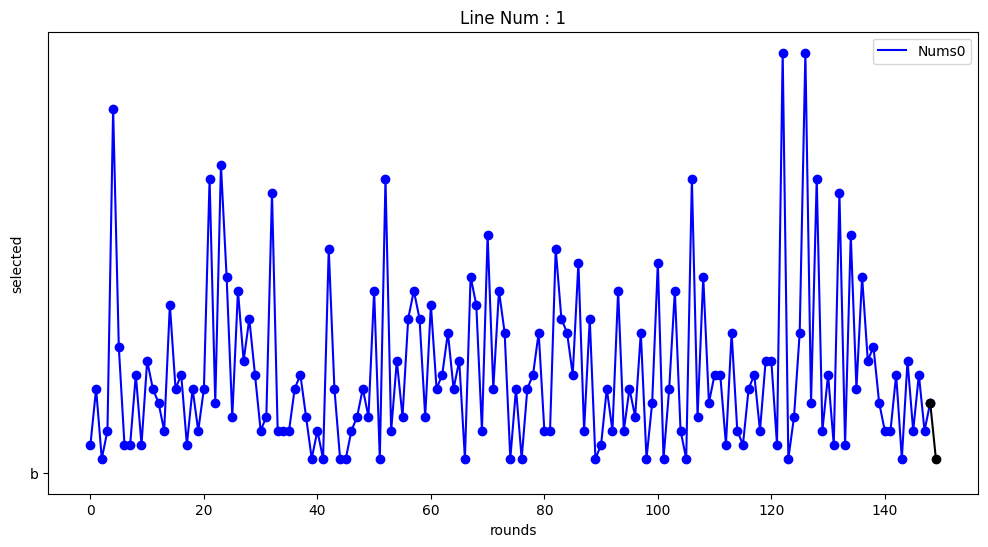

valuse min : [1, 2, 3, 4, 5]
valuse max : [20, 21, 22, 26, 30]
last value : [5, 3, 3, 7, 1, 8, 3, 7, 3, 5]
freq value : [(13, 6), (5, 7), (10, 7), (8, 8), (4, 10), (2, 11), (7, 13), (1, 16), (6, 18), (3, 24)]
select val : 1
최소값 : [3.5, 3.75, 4.0, 4.125, 4.125]
마지막 : [4.875, 4.625, 4.375, 4.625, 4.375]


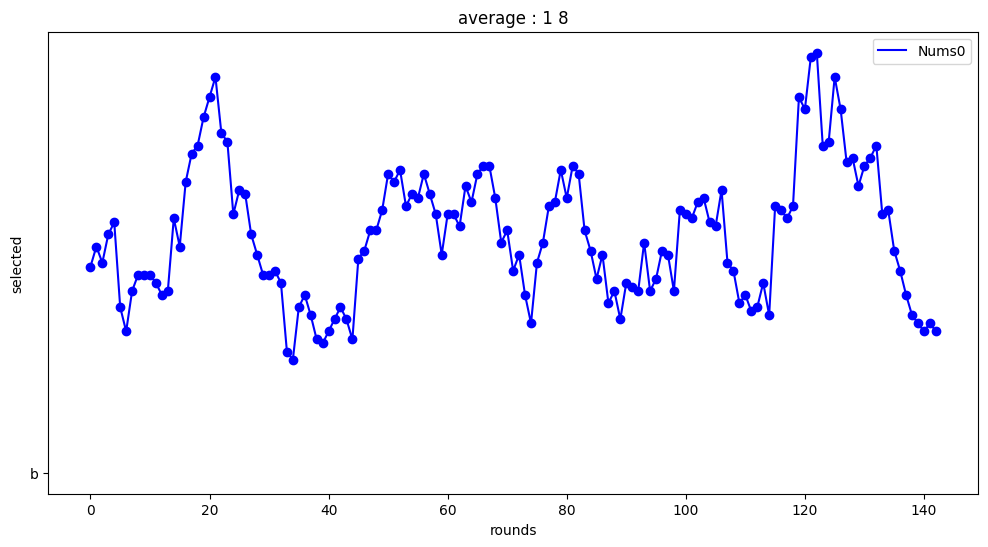

최소값 : [4.0, 4.1, 4.2, 4.3, 4.5]
마지막 : [6.1, 5.4, 4.9, 4.5, 4.1]


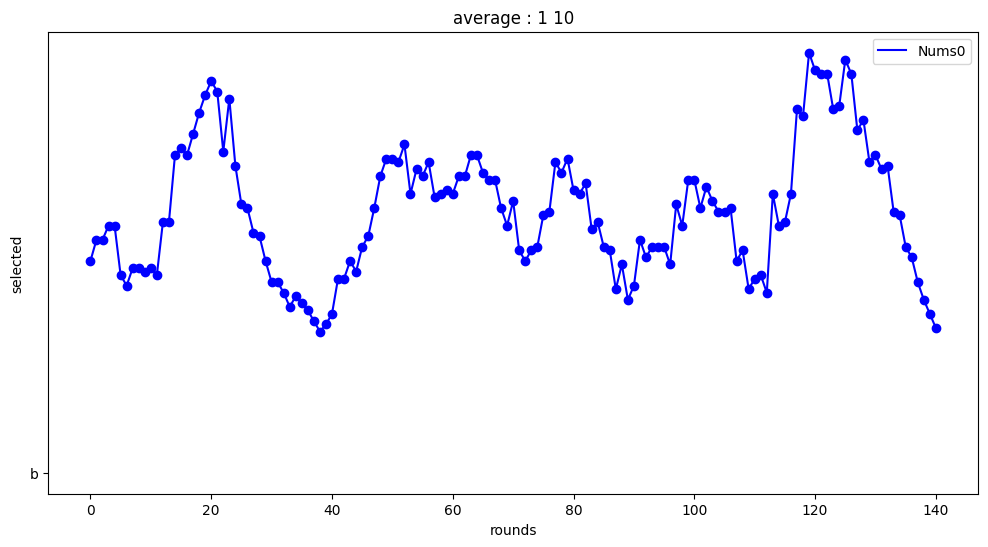

최소값 : [4.230769230769231, 4.230769230769231, 4.3076923076923075, 4.384615384615385, 4.538461538461538]
마지막 : [6.615384615384615, 7.0, 5.923076923076923, 5.846153846153846, 4.846153846153846]


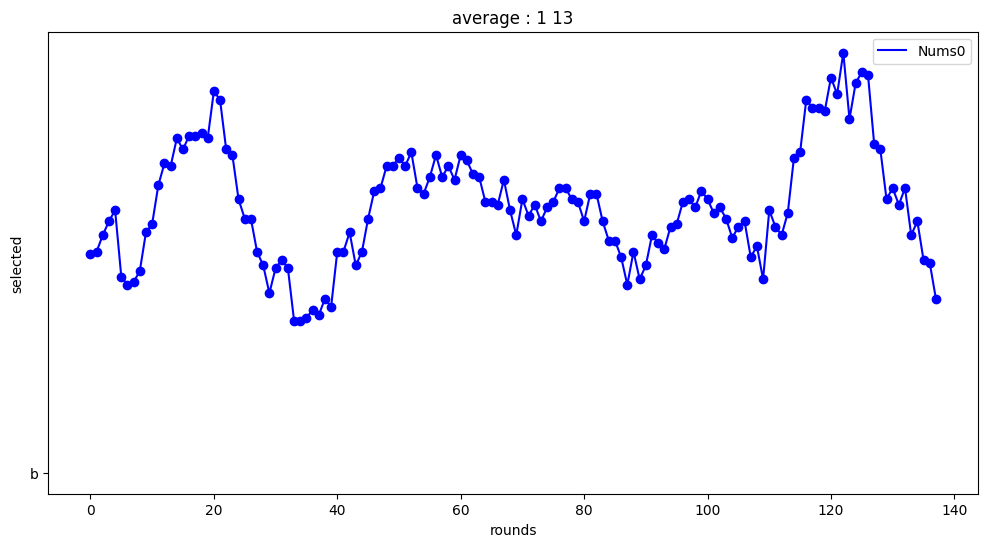

In [25]:
selected = 0
ext_data = 1
draw_scatter(row_list_none_last, f'Line Num : {selected+1}', True, True, [selected], [(selected,ext_data)])
import numpy as np
length = 8
my_list = row_list_none_last[selected] + [ext_data]
ordered = my_list.copy()
ordered.sort()
ordered_dict = {}
for i in ordered:
    if i not in ordered_dict:
        ordered_dict[i] = 1
    else:
        ordered_dict[i] += 1
ordered_dict_sorted = sorted(ordered_dict.items(), key=lambda item: item[1])
ordered = list(set(ordered))
print(f'valuse min : {ordered[:5]}')
print(f'valuse max : {ordered[-5:]}')
print(f'last value : {row_list_none_last[0][-10:]}')
print(f'freq value : {ordered_dict_sorted[-10:]}')
print(f'select val : {ext_data}')
draw_average(my_list, length=8, selected=selected)
draw_average(my_list, length=10, selected=selected)
draw_average(my_list, length=13, selected=selected)
candidate[selected] = ext_data

/tmp/ipykernel_39198/3843253644.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
/tmp/ipykernel_39198/3843253644.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(loc, last[show_col], 'bo', color='k')


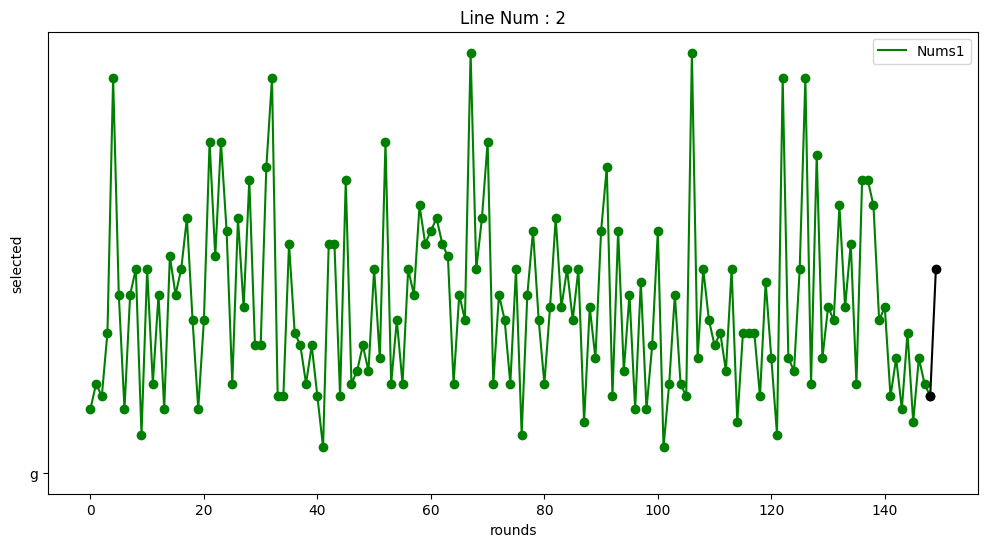

valuse min : [2, 3, 4, 5, 6]
valuse max : [24, 25, 26, 31, 33]
last value : [5, 3, 3, 7, 1, 8, 3, 7, 3, 5]
freq value : [(31, 4), (8, 5), (20, 5), (18, 6), (19, 6), (5, 7), (10, 7), (11, 7), (13, 7), (9, 8), (6, 10), (12, 10), (14, 10), (16, 13), (7, 16)]
select val : 16
최소값 : [7.125, 8.0, 8.375, 8.625, 8.75]
마지막 : [10.125, 8.625, 8.0, 7.125, 8.375]


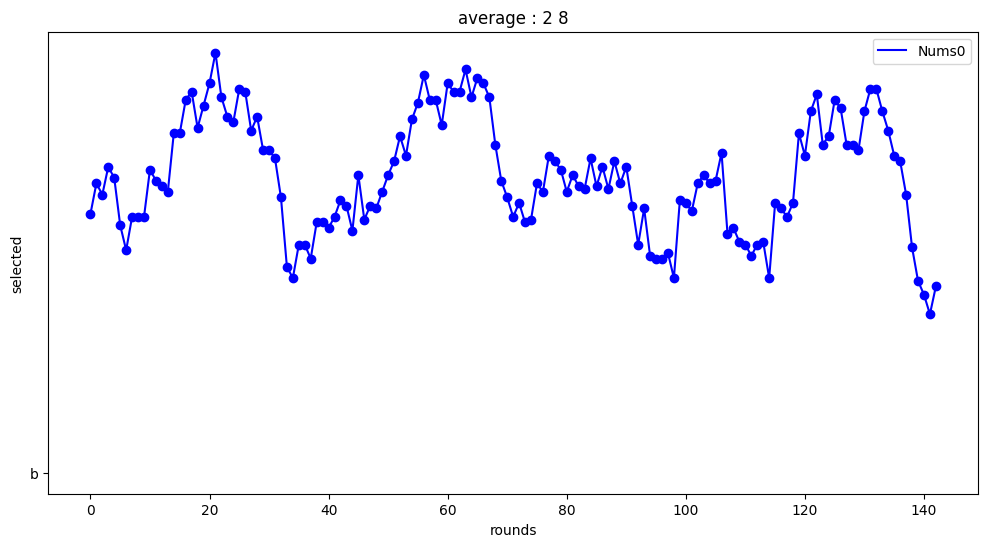

최소값 : [8.2, 8.6, 9.0, 9.4, 9.4]
마지막 : [12.7, 11.3, 9.7, 8.2, 8.6]


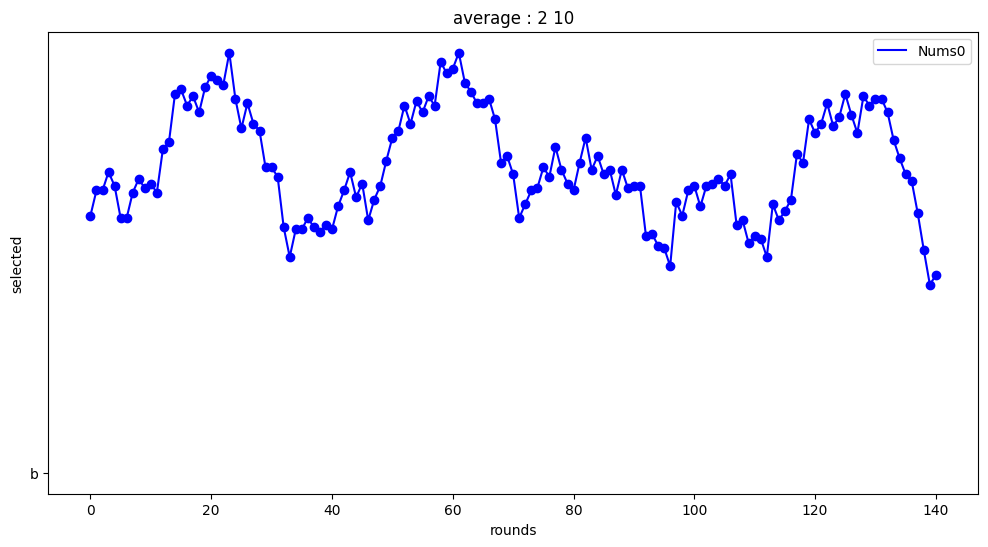

최소값 : [9.76923076923077, 10.076923076923077, 10.076923076923077, 10.23076923076923, 10.461538461538462]
마지막 : [12.692307692307692, 12.384615384615385, 11.538461538461538, 11.461538461538462, 10.923076923076923]


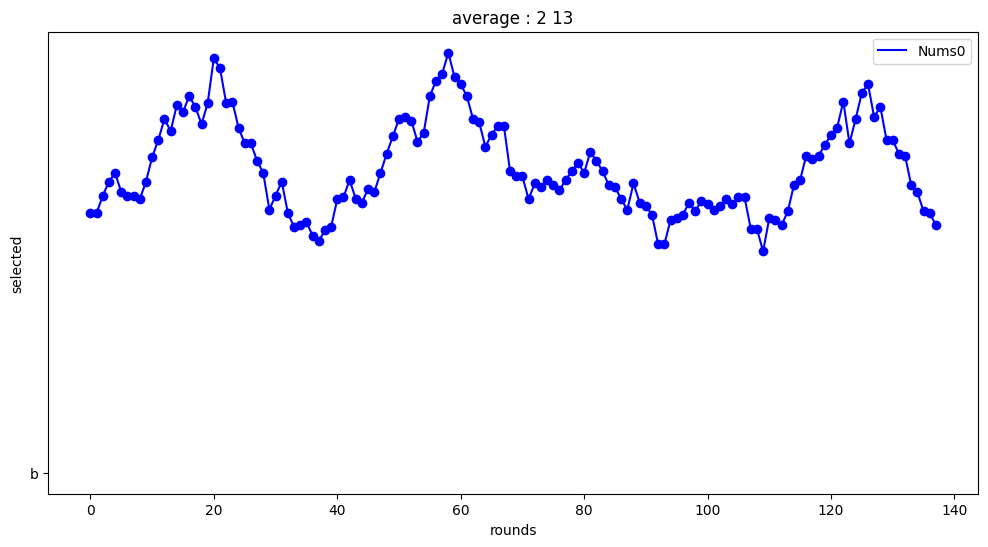

In [35]:
selected = 1
ext_data = 16
draw_scatter(row_list_none_last, f'Line Num : {selected+1}', True, True, [selected], [(selected,ext_data)])
import numpy as np
length = 8
my_list = row_list_none_last[selected] + [ext_data]
ordered = my_list.copy()
ordered.sort()
ordered_dict = {}
for i in ordered:
    if i not in ordered_dict:
        ordered_dict[i] = 1
    else:
        ordered_dict[i] += 1
ordered_dict_sorted = sorted(ordered_dict.items(), key=lambda item: item[1])
ordered = list(set(ordered))
print(f'valuse min : {ordered[:5]}')
print(f'valuse max : {ordered[-5:]}')
print(f'last value : {row_list_none_last[0][-10:]}')
print(f'freq value : {ordered_dict_sorted[-15:]}')
print(f'select val : {ext_data}')
draw_average(my_list, length=8, selected=selected)
draw_average(my_list, length=10, selected=selected)
draw_average(my_list, length=13, selected=selected)
candidate[selected] = ext_data

/tmp/ipykernel_39198/3843253644.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
/tmp/ipykernel_39198/3843253644.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(loc, last[show_col], 'bo', color='k')


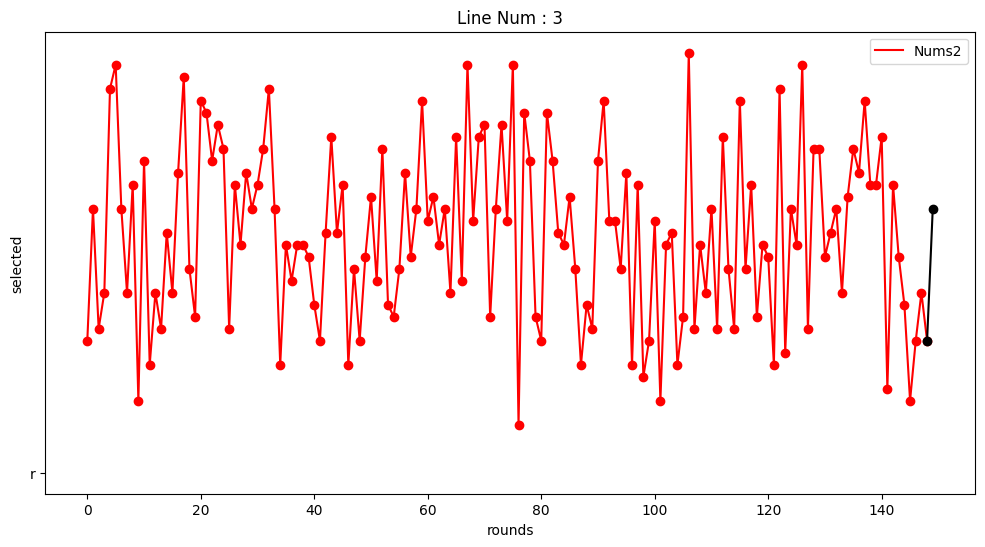

valuse min : [4, 6, 7, 8, 9]
valuse max : [31, 32, 33, 34, 35]
last value : [5, 3, 3, 7, 1, 8, 3, 7, 3, 5]
freq value : [(21, 6), (27, 6), (9, 7), (11, 7), (17, 7), (12, 8), (15, 8), (24, 9), (19, 10), (22, 11)]
select val : 22
최소값 : [13.25, 13.375, 14.75, 14.75, 15.125]
마지막 : [18.125, 16.5, 15.375, 13.25, 15.125]


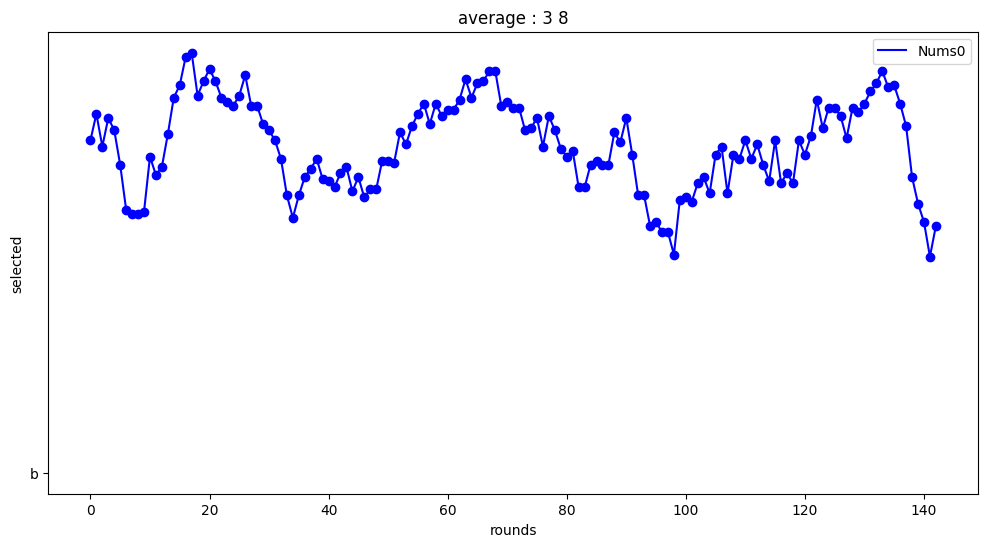

최소값 : [14.0, 15.2, 15.4, 15.6, 15.8]
마지막 : [20.1, 18.7, 17.1, 15.8, 15.6]


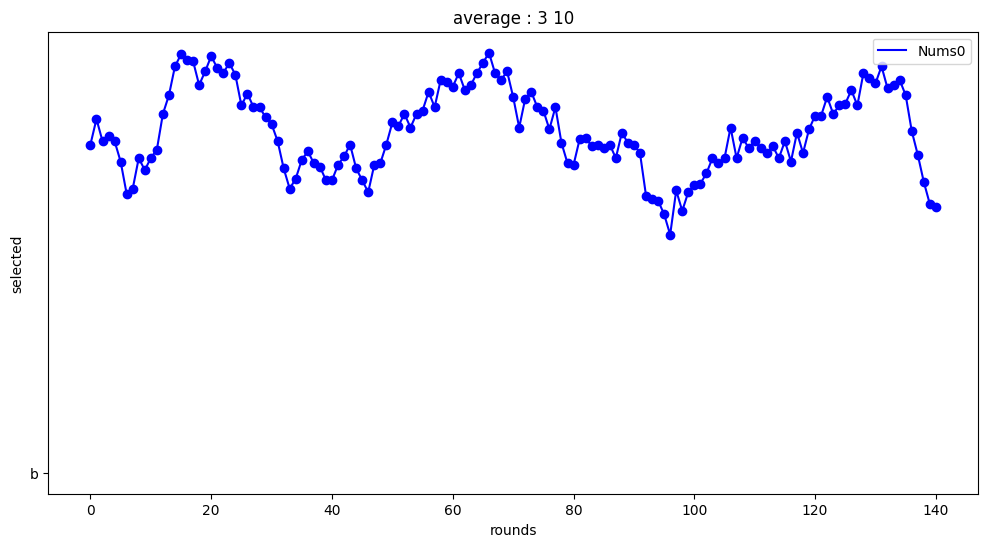

최소값 : [15.615384615384615, 15.846153846153847, 16.153846153846153, 16.23076923076923, 16.307692307692307]
마지막 : [20.46153846153846, 20.153846153846153, 19.53846153846154, 18.307692307692307, 18.076923076923077]


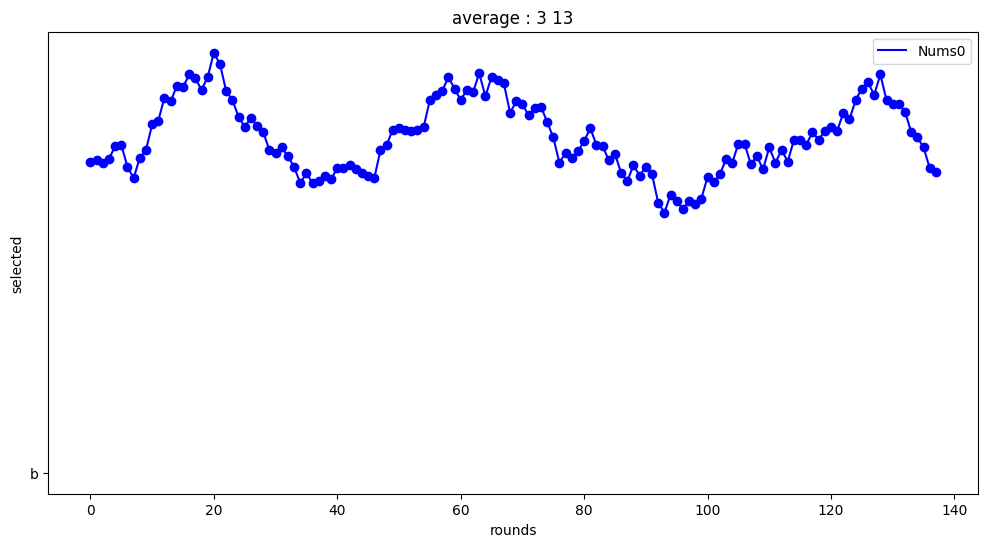

In [37]:
selected = 2
ext_data = 22
draw_scatter(row_list_none_last, f'Line Num : {selected+1}', True, True, [selected], [(selected,ext_data)])
import numpy as np
length = 8
my_list = row_list_none_last[selected] + [ext_data]
ordered = my_list.copy()
ordered.sort()
ordered_dict = {}
for i in ordered:
    if i not in ordered_dict:
        ordered_dict[i] = 1
    else:
        ordered_dict[i] += 1
ordered_dict_sorted = sorted(ordered_dict.items(), key=lambda item: item[1])
ordered = list(set(ordered))
print(f'valuse min : {ordered[:5]}')
print(f'valuse max : {ordered[-5:]}')
print(f'last value : {row_list_none_last[0][-10:]}')
print(f'freq value : {ordered_dict_sorted[-10:]}')
print(f'select val : {ext_data}')
draw_average(my_list, length=8, selected=selected)
draw_average(my_list, length=10, selected=selected)
draw_average(my_list, length=13, selected=selected)
candidate[selected] = ext_data

/tmp/ipykernel_39198/3843253644.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
/tmp/ipykernel_39198/3843253644.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(loc, last[show_col], 'bo', color='k')


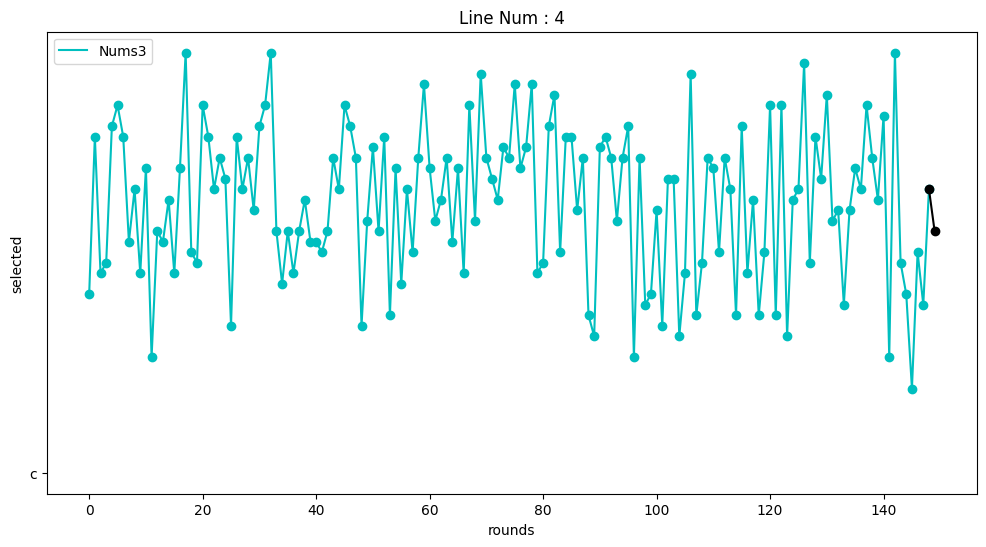

valuse min : [8, 11, 13, 14, 15]
valuse max : [36, 37, 38, 39, 40]
last value : [5, 3, 3, 7, 1, 8, 3, 7, 3, 5]
freq value : [(33, 6), (21, 7), (23, 7), (26, 7), (19, 8), (29, 8), (35, 8), (27, 9), (32, 9), (30, 15)]
select val : 23
최소값 : [20.0, 20.0, 20.875, 21.125, 21.375]
마지막 : [23.25, 22.125, 20.875, 20.0, 21.5]


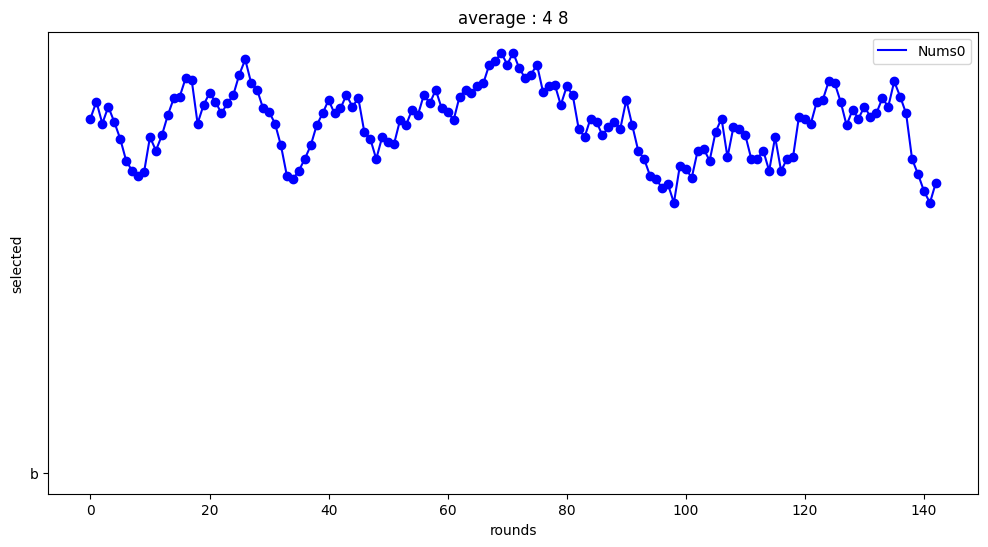

최소값 : [20.1, 21.3, 21.5, 21.7, 21.7]
마지막 : [24.8, 24.2, 22.3, 22.0, 21.7]


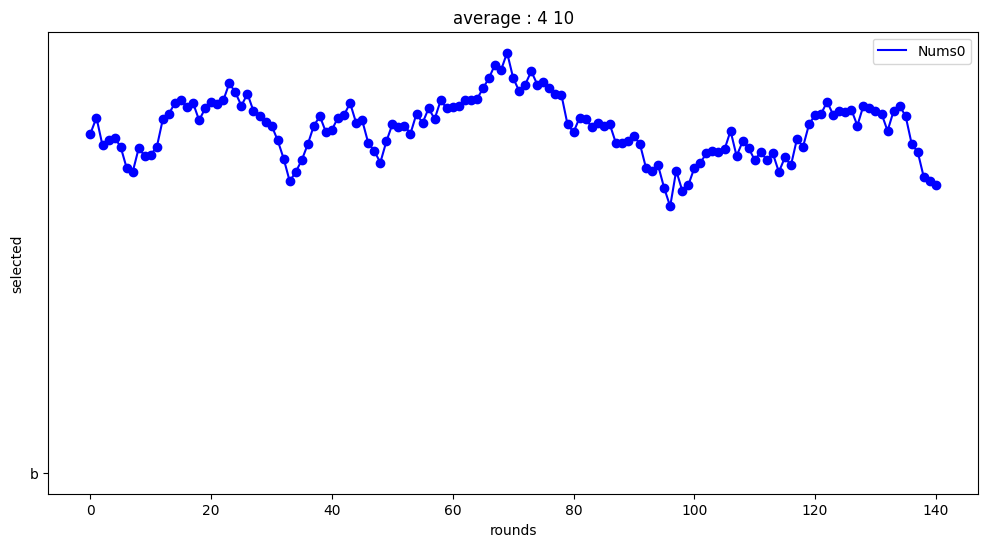

최소값 : [21.076923076923077, 22.076923076923077, 22.153846153846153, 22.46153846153846, 22.53846153846154]
마지막 : [24.46153846153846, 24.846153846153847, 24.153846153846153, 24.0, 23.692307692307693]


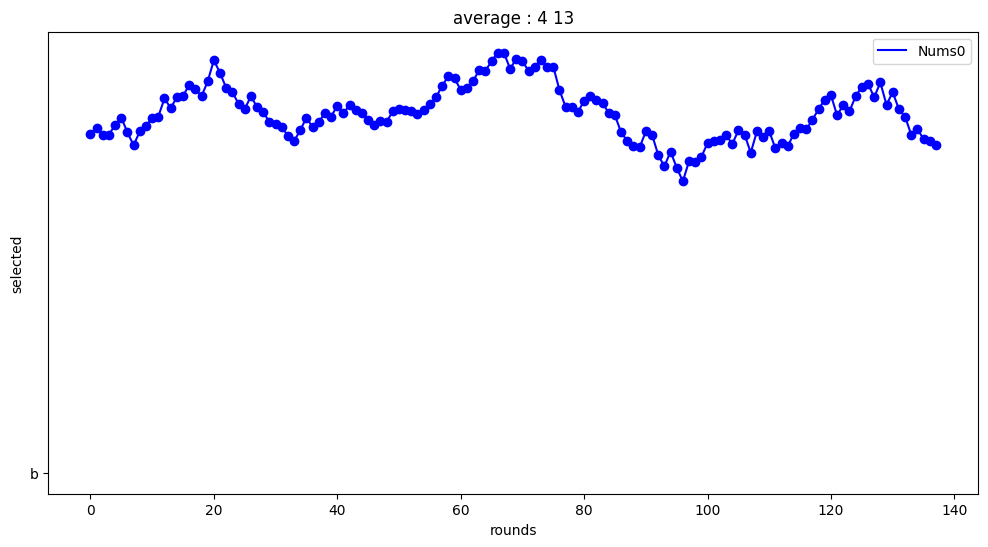

In [42]:
selected = 3
ext_data = 23
draw_scatter(row_list_none_last, f'Line Num : {selected+1}', True, True, [selected], [(selected,ext_data)])
import numpy as np
length = 8
my_list = row_list_none_last[selected] + [ext_data]
ordered = my_list.copy()
ordered.sort()
ordered_dict = {}
for i in ordered:
    if i not in ordered_dict:
        ordered_dict[i] = 1
    else:
        ordered_dict[i] += 1
ordered_dict_sorted = sorted(ordered_dict.items(), key=lambda item: item[1])
ordered = list(set(ordered))
print(f'valuse min : {ordered[:5]}')
print(f'valuse max : {ordered[-5:]}')
print(f'last value : {row_list_none_last[0][-10:]}')
print(f'freq value : {ordered_dict_sorted[-10:]}')
print(f'select val : {ext_data}')
draw_average(my_list, length=8, selected=selected)
draw_average(my_list, length=10, selected=selected)
draw_average(my_list, length=13, selected=selected)
candidate[selected] = ext_data

/tmp/ipykernel_39198/3843253644.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
/tmp/ipykernel_39198/3843253644.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(loc, last[show_col], 'bo', color='k')


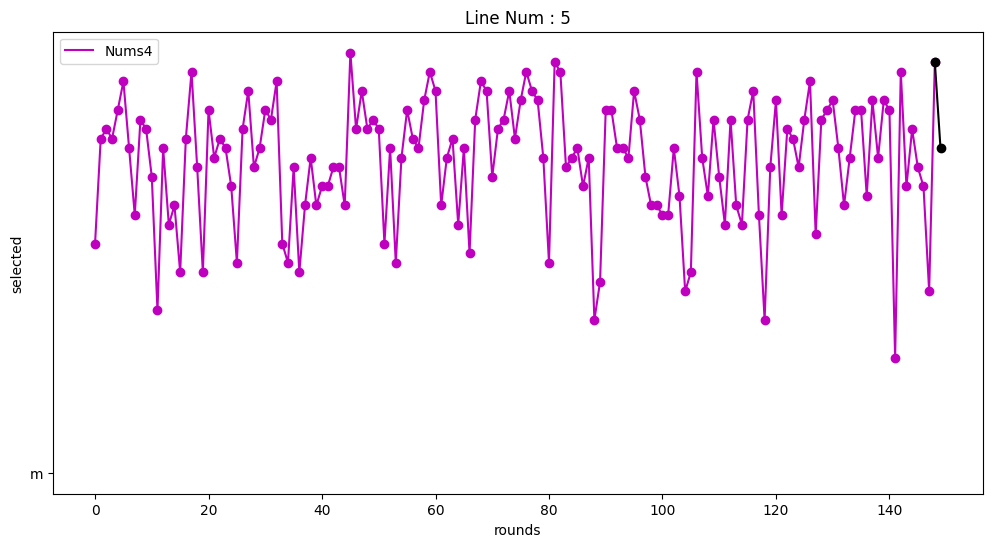

valuse min : [12, 16, 17, 19, 20]
valuse max : [40, 41, 42, 43, 44]
last value : [5, 3, 3, 7, 1, 8, 3, 7, 3, 5]
freq value : [(39, 7), (35, 8), (40, 8), (28, 9), (32, 9), (36, 9), (38, 10), (33, 11), (37, 11), (34, 13)]
select val : 34
최소값 : [26.625, 27.25, 27.875, 28.0, 28.375]
마지막 : [32.75, 32.375, 29.875, 30.5, 33.25]


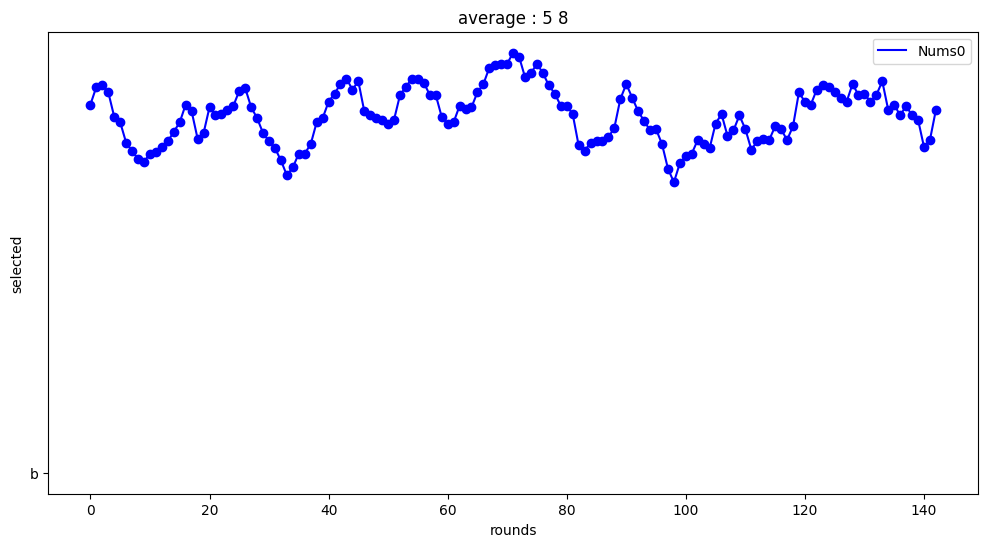

최소값 : [28.0, 28.1, 28.6, 28.7, 28.8]
마지막 : [33.0, 33.1, 31.1, 32.1, 31.6]


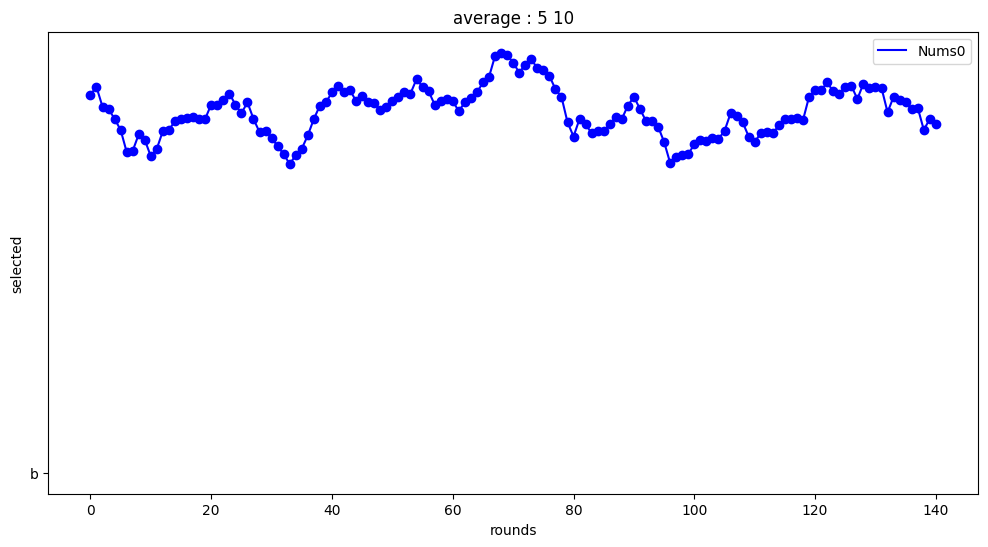

최소값 : [29.307692307692307, 29.46153846153846, 29.53846153846154, 29.615384615384617, 29.615384615384617]
마지막 : [33.76923076923077, 33.53846153846154, 32.07692307692308, 32.46153846153846, 32.84615384615385]


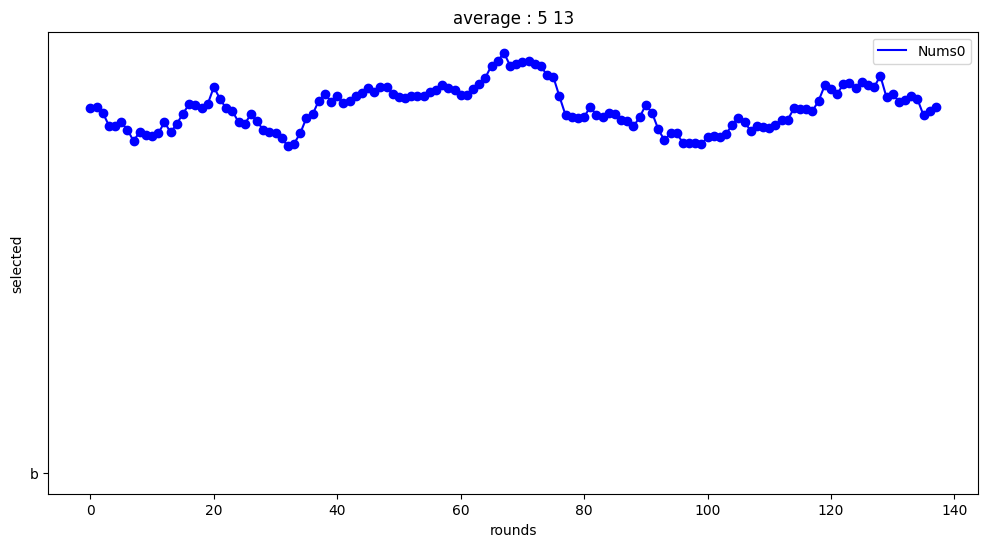

In [43]:
selected = 4
ext_data = 34
draw_scatter(row_list_none_last, f'Line Num : {selected+1}', True, True, [selected], [(selected,ext_data)])
import numpy as np
length = 8
my_list = row_list_none_last[selected] + [ext_data]
ordered = my_list.copy()
ordered.sort()
ordered_dict = {}
for i in ordered:
    if i not in ordered_dict:
        ordered_dict[i] = 1
    else:
        ordered_dict[i] += 1
ordered_dict_sorted = sorted(ordered_dict.items(), key=lambda item: item[1])
ordered = list(set(ordered))
print(f'valuse min : {ordered[:5]}')
print(f'valuse max : {ordered[-5:]}')
print(f'last value : {row_list_none_last[0][-10:]}')
print(f'freq value : {ordered_dict_sorted[-10:]}')
print(f'select val : {ext_data}')
draw_average(my_list, length=8, selected=selected)
draw_average(my_list, length=10, selected=selected)
draw_average(my_list, length=13, selected=selected)
candidate[selected] = ext_data

/tmp/ipykernel_39198/3843253644.py:46: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X, Y[show_col], 'bo', colors[show_col], label=label, color=colors[show_col])
/tmp/ipykernel_39198/3843253644.py:58: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(loc, last[show_col], 'bo', color='k')


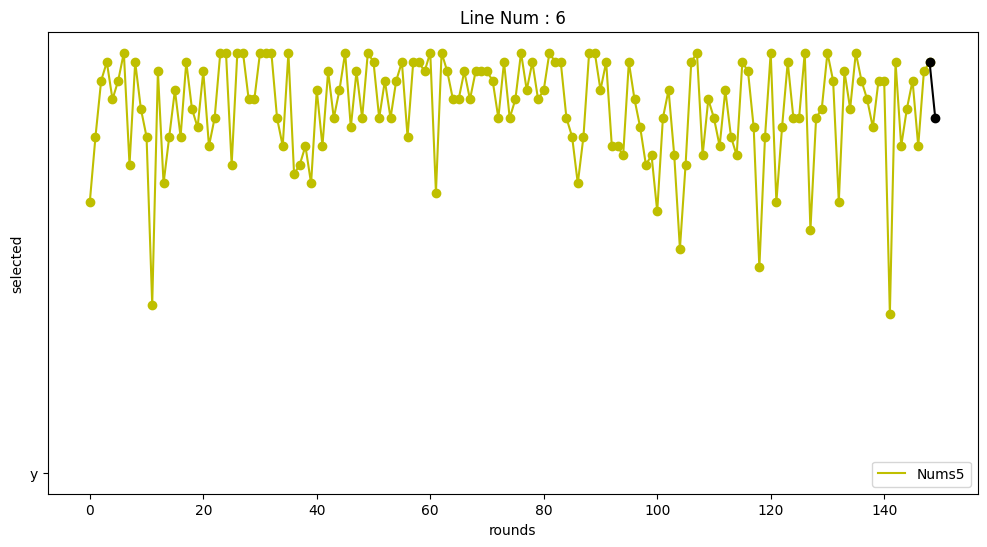

valuse min : [17, 18, 22, 24, 26]
valuse max : [41, 42, 43, 44, 45]
last value : [5, 3, 3, 7, 1, 8, 3, 7, 3, 5]
freq value : [(37, 6), (41, 8), (35, 9), (36, 9), (42, 10), (40, 11), (43, 13), (38, 15), (44, 18), (45, 22)]
select val : 38
최소값 : [33.125, 33.625, 34.5, 35.0, 35.0]
마지막 : [37.25, 37.0, 37.125, 37.375, 40.0]


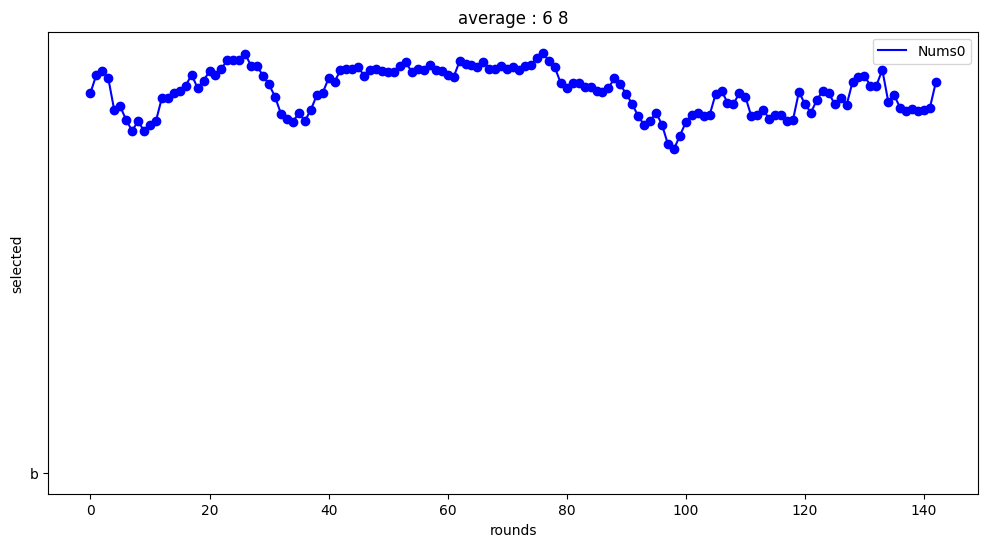

최소값 : [34.2, 34.6, 35.3, 35.4, 35.5]
마지막 : [38.0, 37.3, 37.6, 38.3, 37.9]


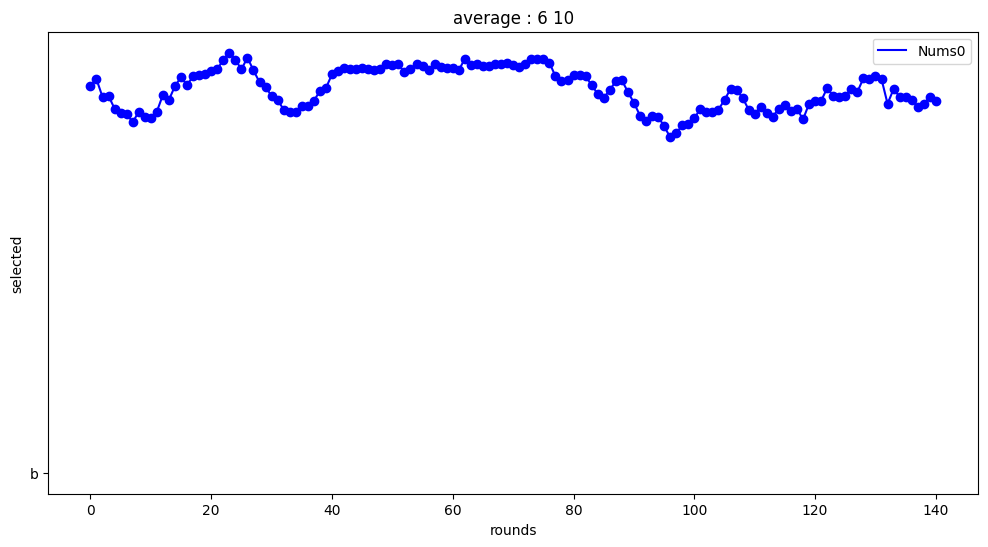

최소값 : [35.0, 35.15384615384615, 35.69230769230769, 35.76923076923077, 35.76923076923077]
마지막 : [39.0, 38.38461538461539, 38.69230769230769, 38.61538461538461, 38.30769230769231]


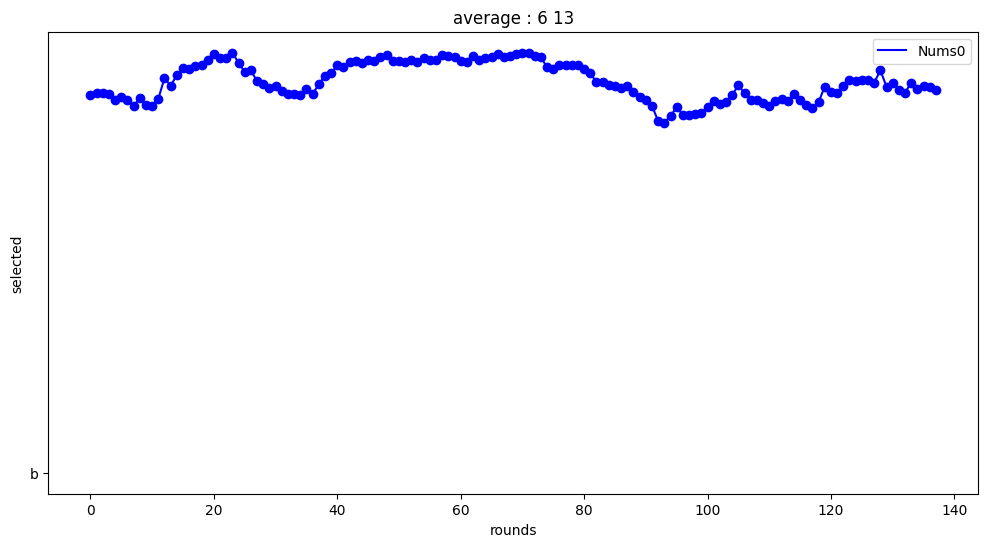

In [45]:
selected = 5
ext_data = 38
draw_scatter(row_list_none_last, f'Line Num : {selected+1}', True, True, [selected], [(selected,ext_data)])
import numpy as np
length = 8
my_list = row_list_none_last[selected] + [ext_data]
ordered = my_list.copy()
ordered.sort()
ordered_dict = {}
for i in ordered:
    if i not in ordered_dict:
        ordered_dict[i] = 1
    else:
        ordered_dict[i] += 1
ordered_dict_sorted = sorted(ordered_dict.items(), key=lambda item: item[1])
ordered = list(set(ordered))
print(f'valuse min : {ordered[:5]}')
print(f'valuse max : {ordered[-5:]}')
print(f'last value : {row_list_none_last[0][-10:]}')
print(f'freq value : {ordered_dict_sorted[-10:]}')
print(f'select val : {ext_data}')
draw_average(my_list, length=8, selected=selected)
draw_average(my_list, length=10, selected=selected)
draw_average(my_list, length=13, selected=selected)
candidate[selected] = ext_data

In [46]:
print(candidate)

{0: 1, 1: 16, 2: 22, 3: 23, 4: 34, 5: 38}


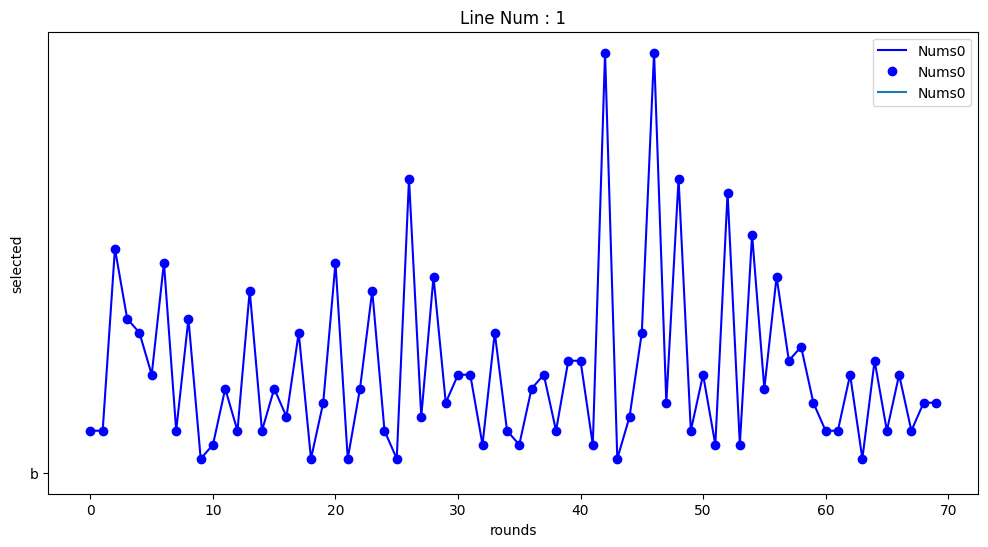

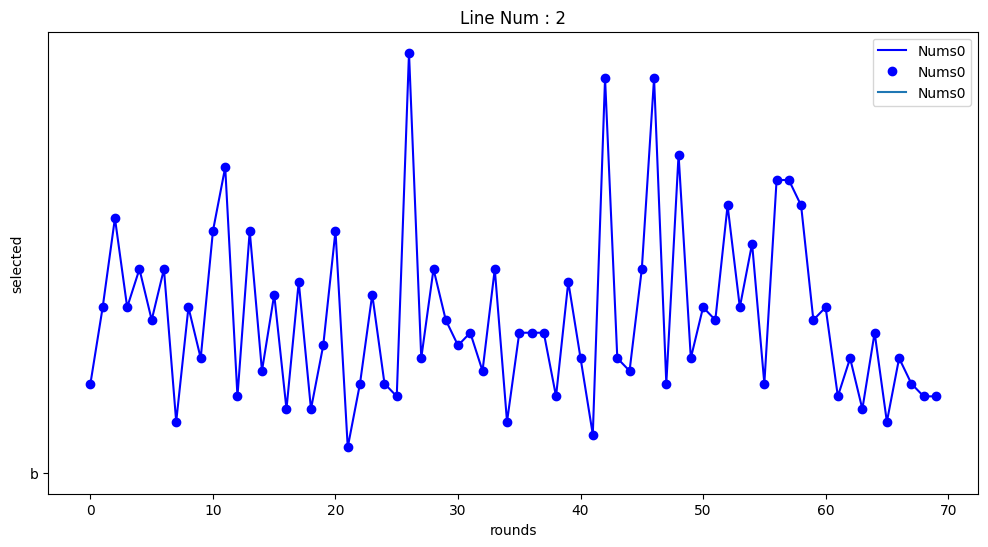

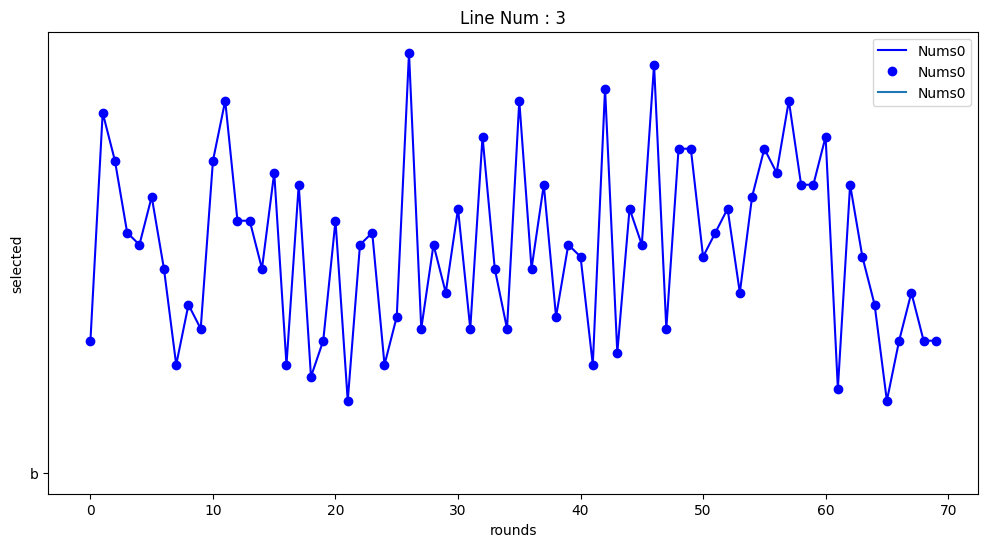

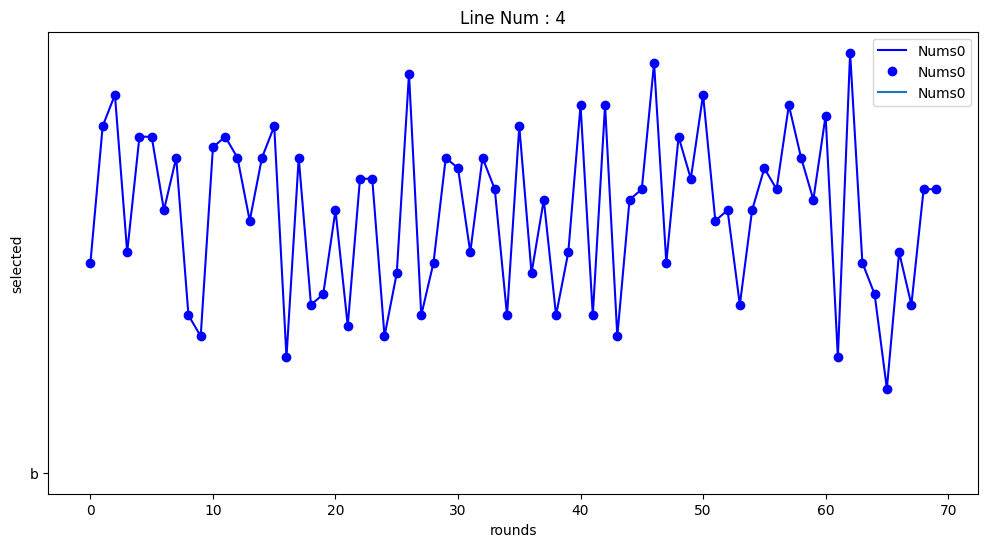

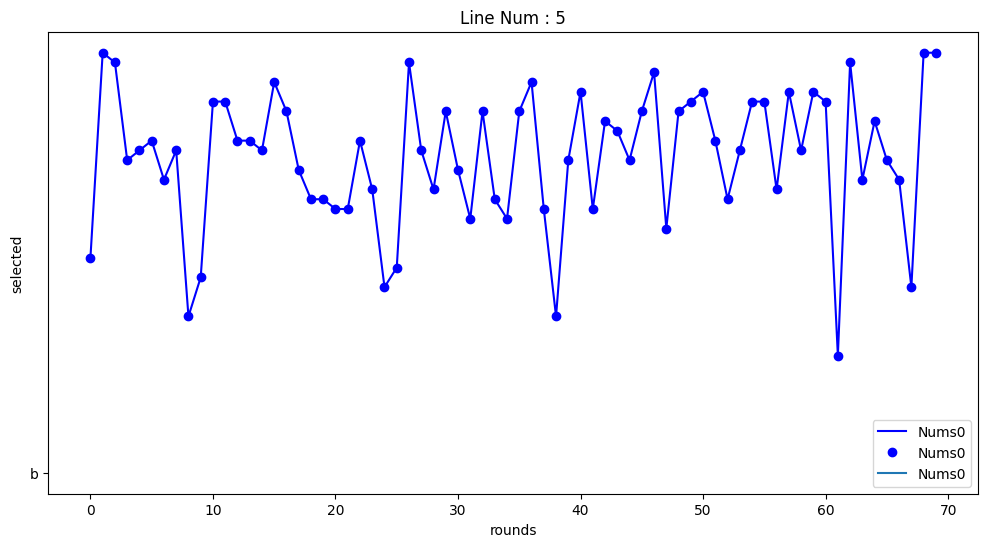

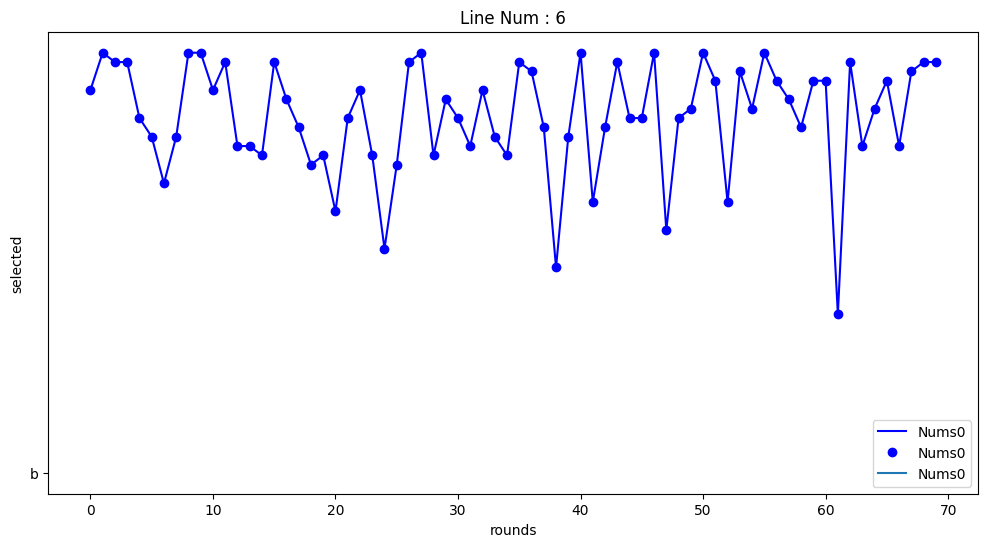

In [115]:
for i in range(6):
    draw_scatter([nums_by_row[i]], f'Line Num : {i+1}')

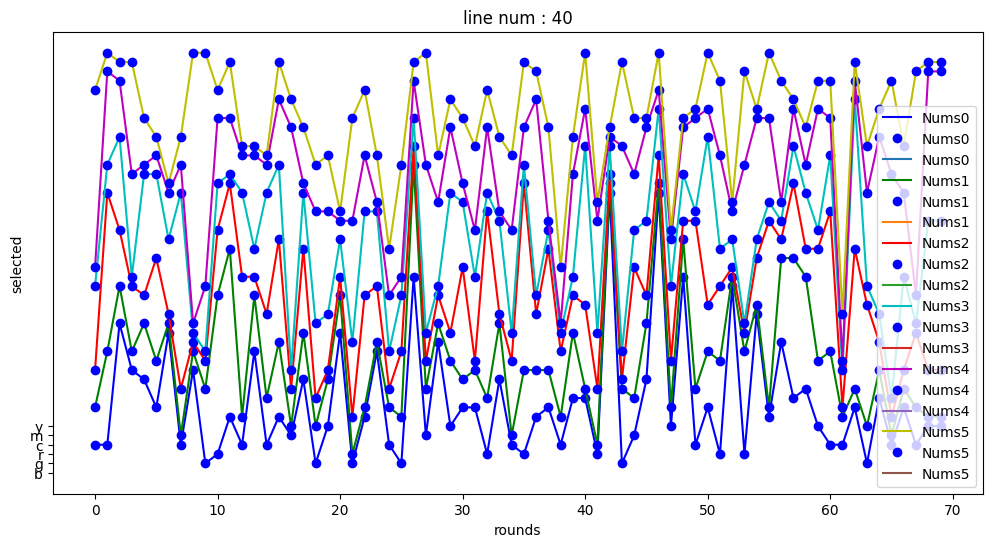

In [116]:
# for i in range(6):
#     draw_scatter([nums_by_row[i]], f'Line Num : {i+1}')
row_list = []
for nums in nums_by_row:
    row_list.append(nums)
draw_scatter(row_list, f'line num : {key}', True, True, [0,1,2,3,4,5])

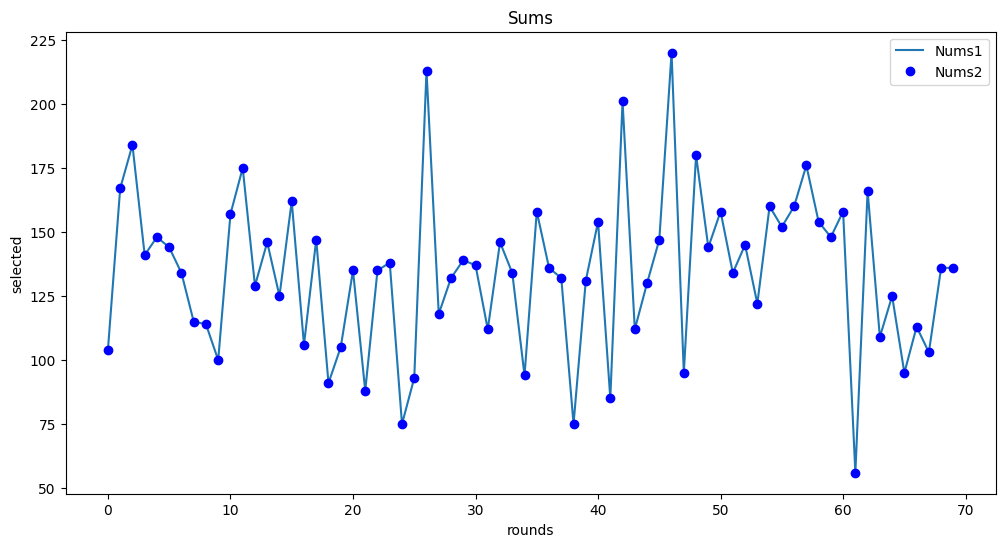

In [55]:
draw_scatter([sums], f'Sums')

In [ ]:
print(sums)
datas = (
    ((1750505603, [[7, 10, 18, 23, 28, 39]]), 0.5),
    ((116885, [[7, 12, 24, 28, 34, 41]]), 76.246),
    ((115367, [[10, 13, 19, 23, 28, 40]]), 61.59),
    ((1750505748, [[6, 9, 20, 25, 31, 42]]), 575.33),
    ((115870, [[8, 11, 19, 26, 30, 43]]), 32.164),
    )
for data in datas:
    print(f'{data[0][1][0]}')
    print(f'sum = {sum(data[0][1][0])}')

In [113]:
print(sums[-20:])
datas = (
    ((115367, [[10, 13, 19, 23, 28, 40]]), 61.59),
    ((116885, [[7, 12, 24, 28, 34, 41]]), 76.246),
    ((114225, [[10, 13, 20, 24, 30, 40]]), 202.36),
    ((11114613, [[8, 12, 21, 26, 31, 39]]), 77.591),
    ((31116739, [[6, 9, 21, 28, 32, 42]]), 730.62006),
    ((114106, [[9, 12, 21, 26, 30, 40]]), 393.44),
    ((31116775, [[8, 13, 21, 27, 34, 41]]), 302.73),
)
for data in datas:
    print(f'{data[0][1][0]}')
    print(f'sum = {sum(data[0][1][0])}')
l1=[[12,21,26,28, 34, 39],
    [13, 20, 24, 30, 40,42]
   ]
for i in l1:
    print(i)
    print(f'sum = {sum(i)}')
last = [3, 7, 15, 16, 19, 43]
print(f'{"*"*20}\nlast : \n{last}\nsum = {sum(last)}')


[144, 158, 134, 145, 122, 160, 152, 160, 176, 154, 148, 158, 56, 166, 109, 125, 95, 113, 103, 103]
[10, 13, 19, 23, 28, 40]
sum = 133
[7, 12, 24, 28, 34, 41]
sum = 146
[10, 13, 20, 24, 30, 40]
sum = 137
[8, 12, 21, 26, 31, 39]
sum = 137
[6, 9, 21, 28, 32, 42]
sum = 138
[9, 12, 21, 26, 30, 40]
sum = 138
[8, 13, 21, 27, 34, 41]
sum = 144
[12, 21, 26, 28, 34, 39]
sum = 160
[13, 20, 24, 30, 40, 42]
sum = 169
********************
last : 
[3, 7, 15, 16, 19, 43]
sum = 103


[144, 158, 134, 145, 122, 160, 152, 160, 176, 154, 148, 158, 56, 166, 109, 125, 95, 113, 103, 138]


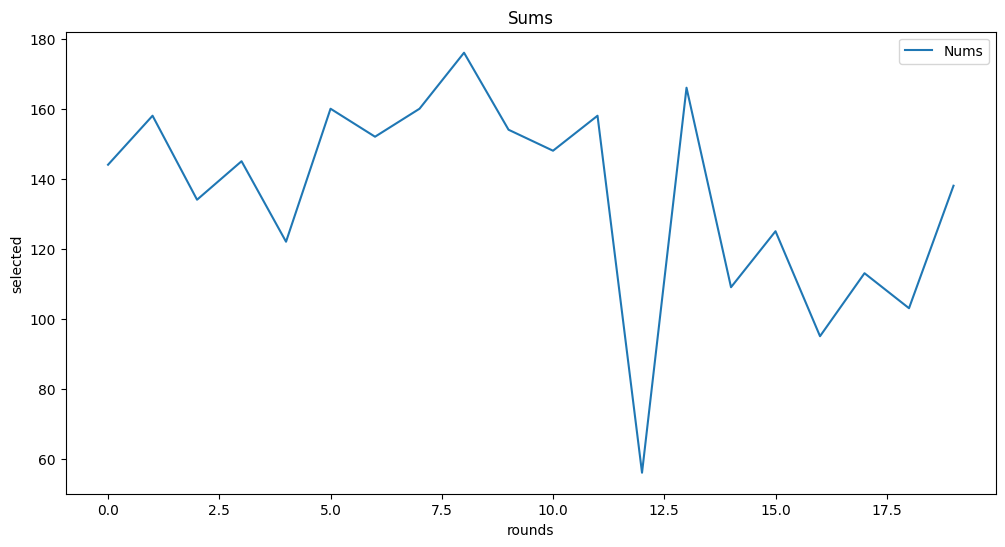

In [115]:
draw_graph(sums[-20:-1]+[138], f'Sums')

In [ ]:
l1=[[12,21,26,28, 34, 39],
    [13, 20, 24, 30, 40,42]]
for i in l1:
    print(sum(i))

In [52]:
candidate = """{0: 1, 1: 16, 2: 22, 3: 23, 4: 34, 5: 38}
{0: 8, 1: 16, 2: 18, 3: 19, 4: 30, 5: 33}
{0: 6, 1: 9, 2: 16, 3: 19, 4: 32, 5: 36}"""
rows = candidate.split("\n")
candidate_nums = []
for row in rows:
    cols = row.split(",")
    nums = []
    for col in cols:
        nums.append(col.split(": ")[1])
    candidate_nums.append(nums)

for candidate_num in candidate_nums:
    print(candidate_num)

['1', '16', '22', '23', '34', '38}']
['8', '16', '18', '19', '30', '33}']
['6', '9', '16', '19', '32', '36}']


In [56]:
for nums in nums_t[1:20]:
    print(nums)

[5, 6, 11, 27, 43, 44]
[3, 7, 15, 16, 19, 43]
[7, 9, 11, 21, 30, 35]
[3, 4, 6, 8, 32, 42]
[8, 11, 14, 17, 36, 39]
[1, 5, 18, 20, 30, 35]
[7, 9, 24, 40, 42, 44]
[3, 6, 7, 11, 12, 17]
[3, 13, 28, 34, 38, 42]
[5, 12, 24, 26, 39, 42]
[9, 21, 24, 30, 33, 37]
[8, 23, 31, 35, 39, 40]
[14, 23, 25, 27, 29, 42]
[6, 7, 27, 29, 38, 45]
[17, 18, 23, 25, 38, 39]
[2, 13, 15, 16, 33, 43]
[20, 21, 22, 25, 28, 29]
[2, 12, 20, 24, 34, 42]
[7, 13, 18, 36, 39, 45]


In [ ]:
(np.float64(30.0), array([[7.3217187]], dtype=float32), 314558)
(np.float64(33.0), array([[13.810979]], dtype=float32), 314558)
(np.float64(35.0), array([[19.010557]], dtype=float32), 314558)
(np.float64(40.0), array([[25.239151]], dtype=float32), 314558)
(np.float64(44.0), array([[34.730366]], dtype=float32), 314558)
(np.float64(45.0), array([[38.54149]], dtype=float32), 314558)